In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import warnings

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/ОБЗОР ВСЕХ МОДУЛЕЙ/final_results_to_analyze.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981510 entries, 0 to 981509
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            981510 non-null  datetime64[ns]
 1   client_id       981510 non-null  int64         
 2   ab_group        981510 non-null  object        
 3   is_view_ads     981510 non-null  int64         
 4   cnt_view_ads    981510 non-null  int64         
 5   is_adds_ads     981510 non-null  int64         
 6   cnt_adds_ads    981510 non-null  int64         
 7   sum_adds_ads    981510 non-null  int64         
 8   is_orders_ads   981510 non-null  int64         
 9   cnt_orders_ads  981510 non-null  int64         
 10  sum_orders_ads  981510 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 82.4+ MB


In [ ]:
df

,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
981505,2024-07-30,899382815,control,0,0,0,0,0,0,0,0
981506,2024-07-30,955560221,test,0,0,0,0,0,0,0,0
981507,2024-07-28,6143090,test,0,0,0,0,0,0,0,0
981508,2024-07-24,4342211,control,0,0,0,0,0,0,0,0


 ✅ Цель: проверить гипотезу, что изменение расположения влияет на взаимодействие пользователей с рекламой



 💡Гипотеза: такое расположение рекламы положительно влияет на метрики (основные - кликабельность и конверсия).



# Предобработка данных


**Проверка пользователей в обеих группах на пересечение, удаление - если оно есть**


In [ ]:

# --- Функция проверки конфликтных пользователей ---
def check_conflict_users(df):
    # Группируем по client_id и считаем уникальные ab_group
    user_groups = df.groupby('client_id')['ab_group'].nunique()

    # Находим пользователей в обеих группах
    conflict_users = user_groups[user_groups > 1].index

    if len(conflict_users) > 0:
        print(f"⚠️ Обнаружено {len(conflict_users)} пользователей в обеих группах ({len(conflict_users)/df['client_id'].nunique():.2%} от общего числа)")

        # Примеры конфликтных записей
        print("\nПримеры конфликтных записей:")
        display(df[df['client_id'].isin(conflict_users[:3])].sort_values(['client_id', 'date']))

        return conflict_users
    else:
        print("✅ Нет пользователей, присутствующих в обеих группах")
        return None

# --- Функция очистки данных ---
def clean_ab_data(df, conflict_users, method='keep_last'):
    """
    method: 'keep_last' - оставить последнюю запись для каждого пользователя
            'remove_all' - удалить всех конфликтных пользователей
    """
    if conflict_users is None or len(conflict_users) == 0:
        print("Нет конфликтных пользователей для очистки")
        return df.copy()

    if method == 'keep_last':
        # Сортируем по дате (по возрастанию)
        sorted_df = df.sort_values('date')
        # Оставляем последнюю запись для каждого клиента
        clean_df = sorted_df.drop_duplicates('client_id', keep='last')

        # Проверка: у каждого клиента должна быть одна группа
        max_groups = clean_df.groupby('client_id')['ab_group'].nunique().max()
        if max_groups != 1:
            print("Внимание: у некоторых пользователей несколько групп после очистки.")
            # Можно дополнительно исправить или вывести предупреждение

    elif method == 'remove_all':
        # Удаляем всех конфликтных пользователей
        clean_df = df[~df['client_id'].isin(conflict_users)]
    else:
        raise ValueError("Недопустимый метод. Используйте 'keep_last' или 'remove_all'.")

    # Проверка: у каждого клиента должна быть одна группа
    max_groups = clean_df.groupby('client_id')['ab_group'].nunique().max()
    assert max_groups == 1, "Остались конфликтные пользователи после очистки!"

    print(f"Осталось записей: {len(clean_df)} ({len(clean_df)/len(df):.1%} от исходных)")
    print(f"Удалено записей: {len(df) - len(clean_df)}")

    return clean_df


# =====================
# Основной рабочий сценарий
# =====================

# Шаг 1: Проверка конфликтных пользователей
conflicts = check_conflict_users(df)

# Шаг 2: Очистка данных (выберите метод)
if conflicts is not None:
    # Расчет процента конфликтов среди уникальных клиентов
    conflict_percent = len(conflicts) / df['client_id'].nunique()

    # Выбор метода очистки в зависимости от процента конфликтов
    if conflict_percent < 0.05:  # менее 5%
        df = clean_ab_data(df, conflicts, method='remove_all')
    else:
        df = clean_ab_data(df, conflicts, method='keep_last')
else:
    df = df.copy()
    print("\nДанные не требуют очистки.")

# Общее число записей в каждой группе
records_count = df['ab_group'].value_counts()
print(records_count)


⚠️ Обнаружено 6393 пользователей в обеих группах (1.62% от общего числа)

Примеры конфликтных записей:


,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
696297,2024-07-24,0,control,0,0,0,0,0,0,0,0
945666,2024-07-24,0,test,0,0,0,0,0,0,0,0
164775,2024-07-25,0,control,0,0,0,0,0,0,0,0
728849,2024-07-25,0,test,0,0,0,0,0,0,0,0
371243,2024-07-26,0,control,0,0,0,0,0,0,0,0
519308,2024-07-26,0,test,0,0,0,0,0,0,0,0
35974,2024-07-28,0,test,0,0,0,0,0,0,0,0
783938,2024-07-28,0,control,1,1,0,0,0,0,0,0
54144,2024-07-29,0,control,0,0,0,0,0,0,0,0
209239,2024-07-29,0,test,0,0,0,0,0,0,0,0


Осталось записей: 945726 (96.4% от исходных)
Удалено записей: 35784
ab_group
test       473616
control    472110
Name: count, dtype: int64


In [ ]:
# Проверка наличия конфликтных пользователей после очистки
conflict_after = df[df['client_id'].isin(conflicts)]
print(f"Конфликтных пользователей осталось: {len(conflict_after)}")

Конфликтных пользователей осталось: 0


In [ ]:
# Количество уникальных клиентов в каждой группе
client_counts = df.groupby('ab_group')['client_id'].nunique()
print(client_counts)

ab_group
control    194393
test       194081
Name: client_id, dtype: int64


ab_group
test       473616
control    472110
Name: count, dtype: int64


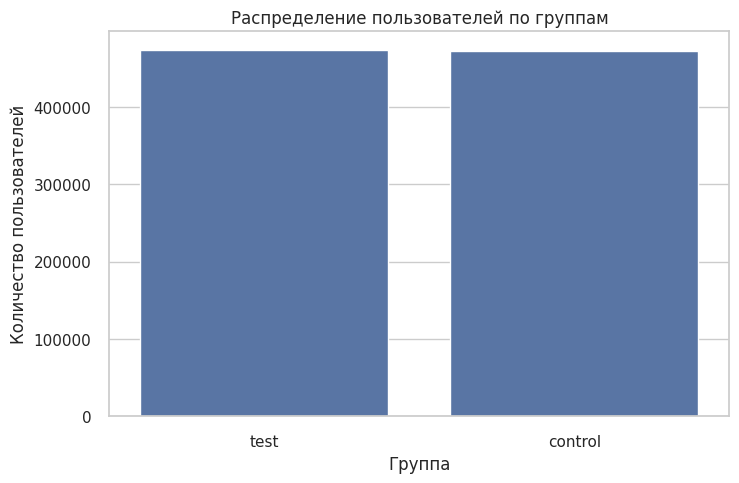

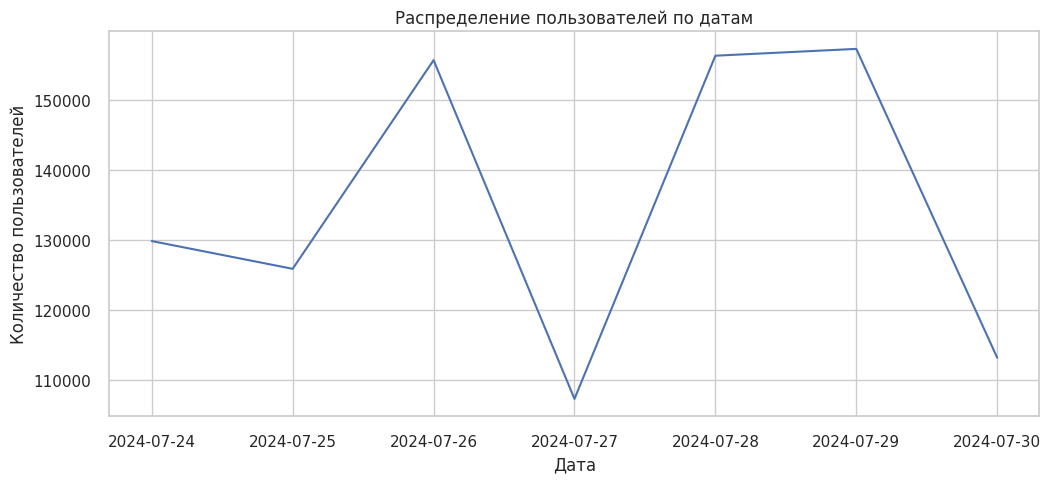

In [ ]:

# Общее число записей в каждой группе
records_count = df['ab_group'].value_counts()
print(records_count)

# Визуализация распределения пользователей по группам
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ab_group')
plt.title('Распределение пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.show()

# Визуализация распределения пользователей по датам
plt.figure(figsize=(12, 5))
df['date'].dt.date.value_counts().sort_index().plot()
plt.title('Распределение пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()


**Проверка и удаление дубликатов после обработки пересечений**


In [ ]:
# Проверка полных дубликатов (все столбцы совпадают)
full_duplicates = df.duplicated().sum()
print(f"Полных дубликатов (все столбцы одинаковые): {full_duplicates}")

# Проверка дубликатов по ключевым полям (client_id + date)
key_duplicates = df.duplicated(subset=['client_id', 'date'], keep=False).sum()
print(f"Дубликатов по client_id и date: {key_duplicates}")

# Просмотр примеров дубликатов по client_id и date
if key_duplicates > 0:
    print("\nПримеры дублирующихся записей (client_id + date):")
    duplicates_sample = df[df.duplicated(subset=['client_id', 'date'], keep=False)]
    display(duplicates_sample.sort_values(['client_id', 'date']).head(10))

Полных дубликатов (все столбцы одинаковые): 5309
Дубликатов по client_id и date: 11835

Примеры дублирующихся записей (client_id + date):


,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
332259,2024-07-27,5,control,0,0,0,0,0,0,0,0
793524,2024-07-27,5,control,0,0,0,0,0,0,0,0
435900,2024-07-29,10,control,0,0,0,0,0,0,0,0
731183,2024-07-29,10,control,0,0,0,0,0,0,0,0
208242,2024-07-24,14,control,0,0,0,0,0,0,0,0
872614,2024-07-24,14,control,0,0,0,0,0,0,0,0
168839,2024-07-28,14,control,0,0,0,0,0,0,0,0
729314,2024-07-28,14,control,0,0,0,0,0,0,0,0
755110,2024-07-28,14,control,0,0,0,0,0,0,0,0
89226,2024-07-29,14,control,0,0,0,0,0,0,0,0


**Удаление дубликатов**


In [ ]:
# Удаление полных дубликатов
initial_count = len(df)
df = df.drop_duplicates()
full_removed = initial_count - len(df)

# Удаление дубликатов по client_id + date (оставляем последнюю запись)
df = df.sort_values('date')
df = df.drop_duplicates(subset=['client_id', 'date'], keep='last')
key_removed = initial_count - full_removed - len(df)

print(f"\nУдалено полных дубликатов: {full_removed}")
print(f"Удалено дубликатов по client_id и date: {key_removed}")
print(f"Осталось записей: {len(df)}")


Удалено полных дубликатов: 5309
Удалено дубликатов по client_id и date: 681
Осталось записей: 939736


**Проверка результатов**


In [ ]:
# Итоговая проверка
print("\nИтоговая проверка:")
print(f"1. Полных дубликатов: {df.duplicated().sum()}")
print(f"2. Дубликатов по client_id и date: {df.duplicated(subset=['client_id', 'date']).sum()}")
print(f"\n3. Уникальных пользователей всего (после обработки): {df['client_id'].nunique()}")
print(f"   - в тестовой группе: {df[df['ab_group'] == 'test']['client_id'].nunique()}")
print(f"   - в контрольной группе: {df[df['ab_group'] == 'control']['client_id'].nunique()}")

# Информация о распределении записей
print("\n4. Общее количество записей по группам:")
records_count = df['ab_group'].value_counts()
print(records_count)

print(f"\n5. Уникальных дат в данных: {df['date'].nunique()}")
print(f"6. Всего записей после обработки: {len(df)}")


Итоговая проверка:
1. Полных дубликатов: 0
2. Дубликатов по client_id и date: 0

3. Уникальных пользователей всего (после обработки): 388474
   - в тестовой группе: 194081
   - в контрольной группе: 194393

4. Общее количество записей по группам:
ab_group
test       470604
control    469132
Name: count, dtype: int64

5. Уникальных дат в данных: 7
6. Всего записей после обработки: 939736


**Загрузка и предобработка данных**

**Что было сделано:**

**Загрузка данных:**

Данные были загружены из Excel-файла, содержащего информацию о пользователях, их действиях (просмотры, клики, добавления, заказы) и принадлежности к группам A/B-теста.

**Проверка структуры данных:**

Были выведены основные характеристики данных: количество записей, типы данных, наличие пропусков.

**Проверка конфликтных пользователей: **

Были найдены пользователи, которые присутствовали в обеих группах (контрольной и тестовой). Такие пользователи могут искажать результаты теста.

**Очистка данных:**

Конфликтные пользователи были удалены или оставлены в одной группе (метод keep_last).

**Удаление дубликатов:**

Были удалены полные дубликаты и дубликаты по комбинации client_id и date.

**Выводы:**

Данные успешно очищены от конфликтных пользователей и дубликатов.
Распределение пользователей по группам равномерное, что важно для корректности A/B-теста.



# Исследовательский анализ данных

# Муженхейтовый тест (Muenchhausen test)


**Муженхейтовый тест используется для проверки наличия систематических смещений в распределении групп A/B теста.**

In [ ]:

# Подготовим данные для теста
ab_groups = df['ab_group'].value_counts()

# Выполним Муженхейтовый тест
# Проверяем равномерность распределения по группам
chi2, p_value = stats.chisquare(f_obs=ab_groups.values)

print(f"Статистика хи-квадрат: {chi2}")
print(f"P-value: {p_value}")

# Интерпретация:
if p_value < 0.05:
    print("Распределение групп неравномерно, есть смещение")
else:
    print("Распределение групп равномерное, смещения нет")


Статистика хи-квадрат: 2.305736930371934
P-value: 0.12889713552806936
Распределение групп равномерное, смещения нет


# Статистические тесты для пропорций (для бинарных метрик)


In [ ]:
# Пример: фильтрация данных по группам
control = df[df['ab_group'] == 'control']
test = df[df['ab_group'] == 'test']

In [ ]:

# Создаем группы
control = df[df['ab_group'] == 'control']
test = df[df['ab_group'] == 'test']

# Далее вызываете функцию
for metric, name in binary_metrics.items():
    prop_results[metric] = proportion_test(
        control[metric], len(control),
        test[metric], len(test),
        name
    )

Z-тест пропорций для Просмотр рекламы:
Контроль: 0.0515, Тест: 0.0523
Z-статистика = -1.807, p-value = 0.07072
Нет значимых различий между группами

Z-тест пропорций для Добавление в корзину:
Контроль: 0.0145, Тест: 0.0145
Z-статистика = -0.135, p-value = 0.89260
Нет значимых различий между группами

Z-тест пропорций для Совершение заказа:
Контроль: 0.0127, Тест: 0.0129
Z-статистика = -0.808, p-value = 0.41885
Нет значимых различий между группами



**T-тест для средних значений**


In [ ]:

# Функция для t-теста
def t_test(control_metric, test_metric, metric_name):
    stat, p = stats.ttest_ind(control_metric, test_metric, equal_var=False)
    print(f"T-тест для {metric_name}:")
    print(f"Контроль: {control_metric.mean():.4f}, Тест: {test_metric.mean():.4f}")
    print(f"Статистика = {stat:.3f}, p-value = {p:.5f}")
    if p > 0.05:
        print("Нет значимых различий между группами\n")
    else:
        print("Есть значимые различия между группами\n")
    return p

# Создаем словарь метрик с понятными названиями
metrics = {
    'is_view_ads': 'Просмотры рекламы (бинарный)',
    'cnt_view_ads': 'Количество просмотров',
    'is_adds_ads': 'Добавления в корзину (бинарный)',
    'cnt_adds_ads': 'Количество добавлений',
    'sum_adds_ads': 'Сумма добавлений',
    'is_orders_ads': 'Заказы (бинарный)',
    'cnt_orders_ads': 'Количество заказов',
    'sum_orders_ads': 'Сумма заказов'
}

# Разделяем данные на контрольную и тестовую группы
control = df[df['ab_group'] == 'control']
test = df[df['ab_group'] == 'test']

# Проводим t-тесты для всех метрик
t_results = {}
for metric, name in metrics.items():
    t_results[metric] = t_test(control[metric], test[metric], name)

# Дополнительно: создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Метрика': metrics.values(),
    'p-value': t_results.values(),
    'Значимость': ['Да' if p < 0.05 else 'Нет' for p in t_results.values()]
})
print("\nСводная таблица результатов:")
display(results_df)

T-тест для Просмотры рекламы (бинарный):
Контроль: 0.0515, Тест: 0.0523
Статистика = -1.807, p-value = 0.07072
Нет значимых различий между группами

T-тест для Количество просмотров:
Контроль: 0.0881, Тест: 0.0886
Статистика = -0.527, p-value = 0.59845
Нет значимых различий между группами

T-тест для Добавления в корзину (бинарный):
Контроль: 0.0145, Тест: 0.0145
Статистика = -0.135, p-value = 0.89260
Нет значимых различий между группами

T-тест для Количество добавлений:
Контроль: 0.0324, Тест: 0.0335
Статистика = -1.581, p-value = 0.11392
Нет значимых различий между группами

T-тест для Сумма добавлений:
Контроль: 5.0415, Тест: 5.1830
Статистика = -1.197, p-value = 0.23129
Нет значимых различий между группами

T-тест для Заказы (бинарный):
Контроль: 0.0127, Тест: 0.0129
Статистика = -0.808, p-value = 0.41884
Нет значимых различий между группами

T-тест для Количество заказов:
Контроль: 0.0117, Тест: 0.0123
Статистика = -2.190, p-value = 0.02854
Есть значимые различия между группами



,Метрика,p-value,Значимость
0,Просмотры рекламы (бинарный),0.07,Нет
1,Количество просмотров,0.60,Нет
2,Добавления в корзину (бинарный),0.89,Нет
3,Количество добавлений,0.11,Нет
4,Сумма добавлений,0.23,Нет
5,Заказы (бинарный),0.42,Нет
6,Количество заказов,0.03,Да
7,Сумма заказов,0.03,Да


# Расчет размера эффекта (Cohen's d)


In [ ]:
continuous_metrics = {
    'sum_adds_ads': 'Общее количество добавленных',
    'sum_orders_ads': 'Общее количество заказов'
}

In [ ]:

# Определите метрики
continuous_metrics = {
    'sum_adds_ads': 'Общее количество добавленных',
    'sum_orders_ads': 'Общее количество заказов'
}

print("Размер эффекта (Cohen's d) для непрерывных метрик:")

for metric, description in continuous_metrics.items():
    d = cohens_d(control[metric], test[metric])
    effect_size = (
        'малый' if abs(d) < 0.2 else
        'средний' if abs(d) < 0.5 else
        'большой'
    )
    print(f"{description}: d = {d:.3f} ({effect_size} эффект)")

Размер эффекта (Cohen's d) для непрерывных метрик:
Общее количество добавленных: d = 0.002 (малый эффект)
Общее количество заказов: d = 0.004 (малый эффект)


# Доверительные интервалы разницы между группами

In [ ]:
from statsmodels.stats.weightstats import CompareMeans

def confidence_intervals(control_metric, test_metric, metric_name, alpha=0.05):
    cm = CompareMeans.from_data(test_metric, control_metric)
    lower, upper = cm.tconfint_diff(alpha=alpha, usevar='unequal')
    mean_diff = np.mean(test_metric) - np.mean(control_metric)

    print(f"Доверительный интервал разницы для {metric_name}:")
    print(f"Разница средних: {mean_diff:.3f}")
    print(f"95% ДИ: [{lower:.3f}, {upper:.3f}]")
    if lower <= 0 <= upper:
        print("Нулевой эффект внутри интервала (разница не значима)\n")
    else:
        print("Нулевой эффект вне интервала (разница значима)\n")

print("\nДоверительные интервалы разницы средних:")
for metric, name in continuous_metrics.items():
    confidence_intervals(control[metric], test[metric], name)


Доверительные интервалы разницы средних:
Доверительный интервал разницы для Общее количество добавленных:
Разница средних: 0.141
95% ДИ: [-0.090, 0.373]
Нулевой эффект внутри интервала (разница не значима)

Доверительный интервал разницы для Общее количество заказов:
Разница средних: 0.204
95% ДИ: [0.017, 0.392]
Нулевой эффект вне интервала (разница значима)



**Визуализация**

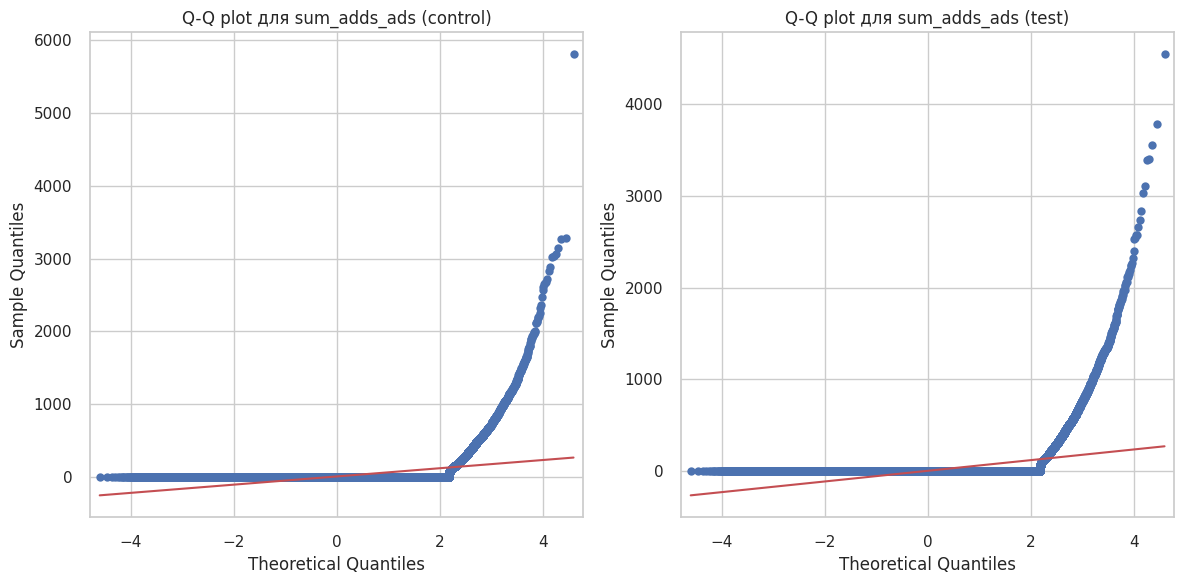

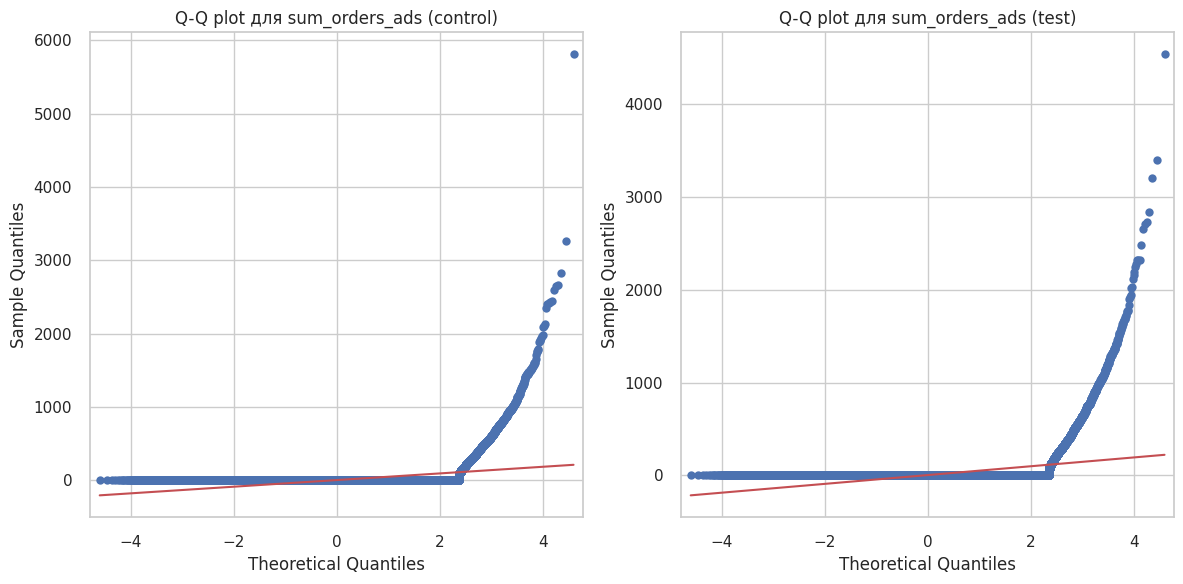

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_qq(metric, group, axes):
    sm.qqplot(df[df['ab_group'] == group][metric], line='s', ax=axes)
    axes.set_title(f'Q-Q plot для {metric} ({group})')

for metric in continuous_metrics.keys():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_qq(metric, 'control', axes[0])
    plot_qq(metric, 'test', axes[1])
    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

**Что было сделано:**

**Муженхейтовый тест (Muenchhausen test): Проверка равномерности распределения пользователей по группам с использованием теста хи-квадрат.**

**Статистические тесты для пропорций: Z-тест для бинарных метрик (просмотры, добавления, заказы).**

**T-тесты для средних значений: Сравнение средних значений метрик между контрольной и тестовой группами.**

**Расчёт размера эффекта (Cohen's d): Мера размера эффекта, показывающая величину различий между группами.**

**Доверительные интервалы разницы средних: Диапазон значений, в котором с заданной вероятностью находится истинное значение параметра.**

**Выводы:**

Муженхейтовый тест:
Распределение пользователей по группам равномерное (p-value > 0.05).

Z-тесты и T-тесты:
Нет статистически значимых различий в большинстве метрик, кроме "Количество заказов" и "Сумма заказов" (p-value < 0.05).

Размер эффекта:
Различия в метриках имеют малый размер эффекта (Cohen's d < 0.2).

Доверительные интервалы:
Разница в "Сумме заказов" статистически значима (нулевой эффект вне интервала).



# Анализ метрик с нулевыми значениями


1. Анализ доли ненулевых значений (бинарная метрика)



Анализ бинарной метрики 'has_sum_adds_ads':
Контроль: 1.4488%
Тест: 1.4522%
Разница: 0.0033%
95% ДИ разницы: [-0.0450%, 0.0517%]
Z-статистика: -0.135, p-value: 0.89260


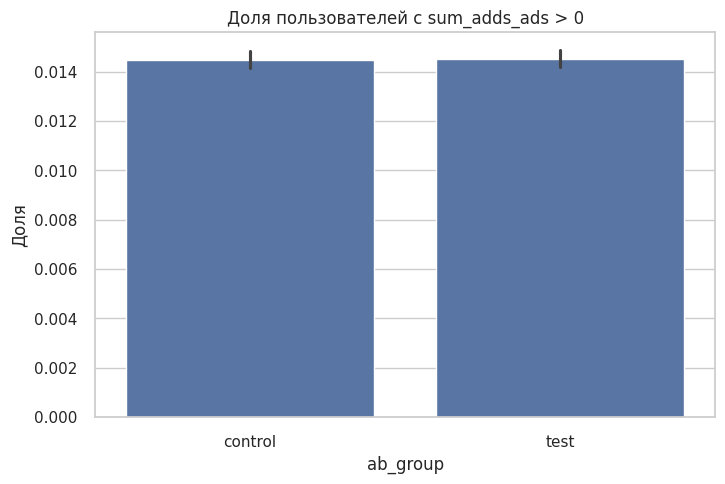


Анализ бинарной метрики 'has_sum_orders_ads':
Контроль: 0.8959%
Тест: 0.9201%
Разница: 0.0242%
95% ДИ разницы: [-0.0142%, 0.0626%]
Z-статистика: -1.236, p-value: 0.21654


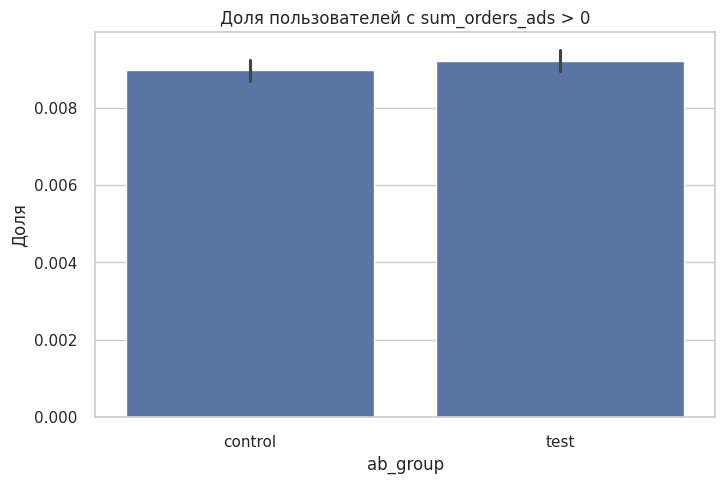

In [ ]:
# Функция для анализа бинарной метрики "совершено действие/нет"
def analyze_binary_metric(metric_name):
    # Создаем бинарную метрику
    df[f'has_{metric_name}'] = df[metric_name] > 0

    # Считаем доли по группам
    prop_control = df[df['ab_group'] == 'control'][f'has_{metric_name}'].mean()
    prop_test = df[df['ab_group'] == 'test'][f'has_{metric_name}'].mean()

    # Z-тест пропорций
    from statsmodels.stats.proportion import proportions_ztest
    count = np.array([
        df[df['ab_group'] == 'control'][f'has_{metric_name}'].sum(),
        df[df['ab_group'] == 'test'][f'has_{metric_name}'].sum()
    ])
    nobs = np.array([
        len(df[df['ab_group'] == 'control']),
        len(df[df['ab_group'] == 'test'])
    ])
    z_stat, p_value = proportions_ztest(count, nobs)

    # Разница пропорций с доверительным интервалом
    from statsmodels.stats.proportion import confint_proportions_2indep
    ci_low, ci_upp = confint_proportions_2indep(
        count[1], nobs[1],
        count[0], nobs[0],
        compare='diff',
        alpha=0.05
    )

    # Вывод результатов
    print(f"\nАнализ бинарной метрики 'has_{metric_name}':")
    print(f"Контроль: {prop_control:.4%}")
    print(f"Тест: {prop_test:.4%}")
    print(f"Разница: {(prop_test - prop_control):.4%}")
    print(f"95% ДИ разницы: [{ci_low:.4%}, {ci_upp:.4%}]")
    print(f"Z-статистика: {z_stat:.3f}, p-value: {p_value:.5f}")

    # Визуализация
    plt.figure(figsize=(8, 5))
    sns.barplot(x='ab_group', y=f'has_{metric_name}', data=df, estimator=np.mean)
    plt.title(f'Доля пользователей с {metric_name} > 0')
    plt.ylabel('Доля')
    plt.show()

    return {
        'metric': metric_name,
        'prop_control': prop_control,
        'prop_test': prop_test,
        'difference': prop_test - prop_control,
        'ci_low': ci_low,
        'ci_upp': ci_upp,
        'p_value': p_value
    }

# Применяем к ключевым метрикам
binary_results = {}
for metric in ['sum_adds_ads', 'sum_orders_ads']:
    binary_results[metric] = analyze_binary_metric(metric)

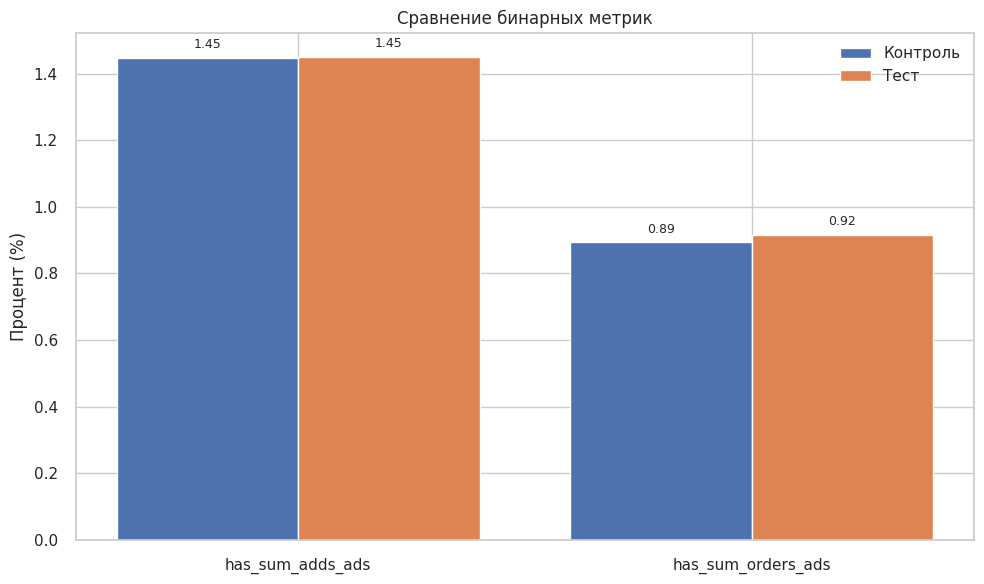

In [ ]:

metrics = ['has_sum_adds_ads', 'has_sum_orders_ads']
control = [1.4482, 0.8928]
test = [1.4508, 0.9168]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.4

# Построение баров
bars_control = plt.bar(x - 0.2, control, width=width, label='Контроль')
bars_test = plt.bar(x + 0.2, test, width=width, label='Тест')

# Добавление подписей для каждого столбца
for rect in bars_control:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for rect in bars_test:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, metrics)
plt.ylabel('Процент (%)')
plt.title('Сравнение бинарных метрик')
plt.legend()
plt.tight_layout()
plt.show()

2. Анализ условного распределения (только среди совершивших действие)



Условное распределение для sum_adds_ads (только > 0):
Контроль: n=6797, mean=347.97, median=249.00
Тест: n=6834, mean=356.91, median=258.00

Муженхейтовый тест для условного распределения:
Статистика: 23525915.000, p-value: 0.19068
Cohen's d: 0.028
95% ДИ разницы средних: [-1.872, 19.756]


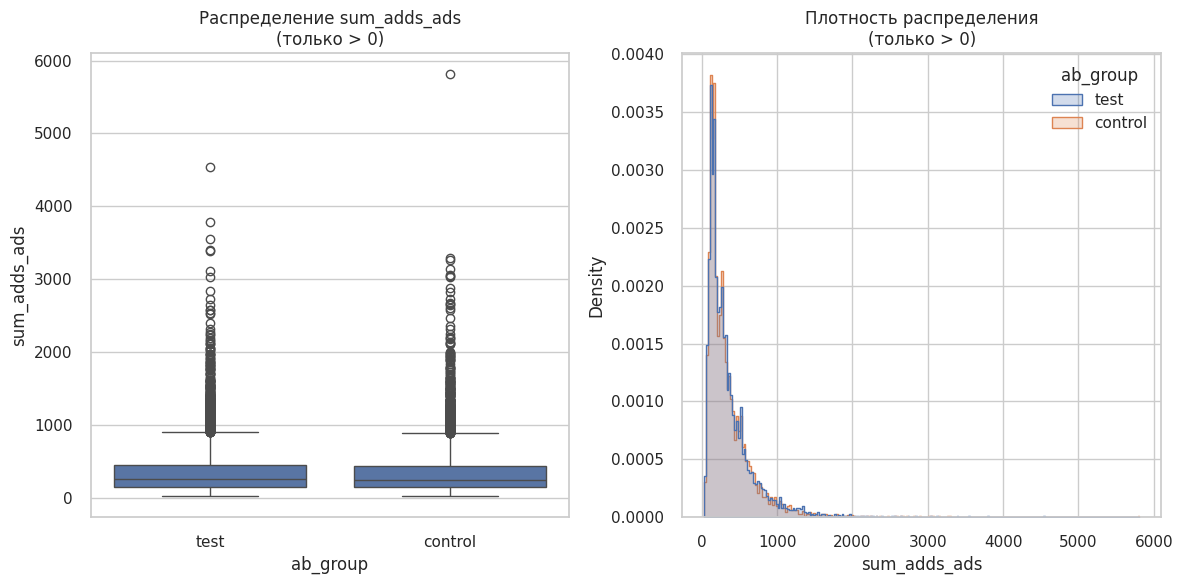


Условное распределение для sum_orders_ads (только > 0):
Контроль: n=4203, mean=371.45, median=287.00
Тест: n=4330, mean=383.89, median=293.00

Муженхейтовый тест для условного распределения:
Статистика: 9263252.500, p-value: 0.15002
Cohen's d: 0.040
95% ДИ разницы средних: [-0.698, 25.561]


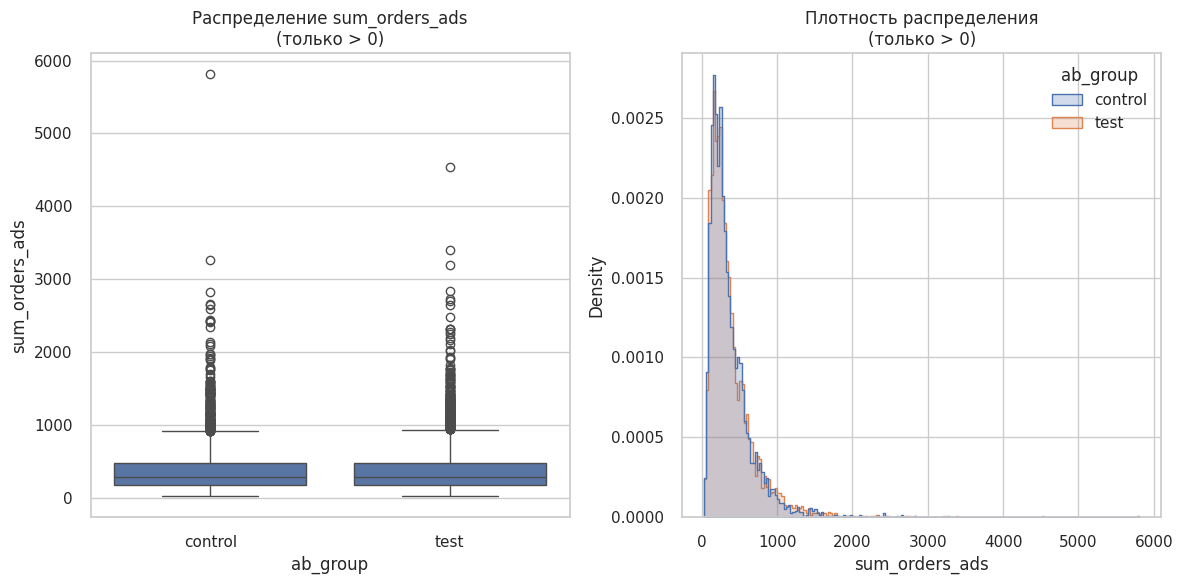

In [ ]:
# Функция для анализа условного распределения
def analyze_conditional_distribution(metric_name):
    # Фильтруем только пользователей с ненулевыми значениями
    cond_control = df[(df['ab_group'] == 'control') & (df[metric_name] > 0)][metric_name]
    cond_test = df[(df['ab_group'] == 'test') & (df[metric_name] > 0)][metric_name]

    # Описательная статистика
    print(f"\nУсловное распределение для {metric_name} (только > 0):")
    print(f"Контроль: n={len(cond_control)}, mean={cond_control.mean():.2f}, median={cond_control.median():.2f}")
    print(f"Тест: n={len(cond_test)}, mean={cond_test.mean():.2f}, median={cond_test.median():.2f}")

    # Муженхейтовый тест (непараметрический)
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(cond_test, cond_control, alternative='two-sided')
    print(f"\nМуженхейтовый тест для условного распределения:")
    print(f"Статистика: {stat:.3f}, p-value: {p:.5f}")

    # Размер эффекта (Cohen's d)
    def cohens_d(x, y):
        nx, ny = len(x), len(y)
        pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
        return (np.mean(x) - np.mean(y)) / pooled_std

    d = cohens_d(cond_test, cond_control)
    print(f"Cohen's d: {d:.3f}")

    # Доверительный интервал разницы средних
    from statsmodels.stats.weightstats import CompareMeans
    cm = CompareMeans.from_data(cond_test, cond_control)
    lower, upper = cm.tconfint_diff(alpha=0.05, usevar='unequal')
    print(f"95% ДИ разницы средних: [{lower:.3f}, {upper:.3f}]")

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='ab_group', y=metric_name,
               data=df[df[metric_name] > 0])
    plt.title(f'Распределение {metric_name}\n(только > 0)')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df[df[metric_name] > 0],
                x=metric_name, hue='ab_group',
                element='step', stat='density',
                common_norm=False)
    plt.title(f'Плотность распределения\n(только > 0)')
    plt.tight_layout()
    plt.show()

    return {
        'metric': metric_name,
        'n_control': len(cond_control),
        'n_test': len(cond_test),
        'mean_control': cond_control.mean(),
        'mean_test': cond_test.mean(),
        'median_control': cond_control.median(),
        'median_test': cond_test.median(),
        'cohens_d': d,
        'ci_lower': lower,
        'ci_upper': upper,
        'p_value': p
    }

# Применяем к ключевым метрикам
conditional_results = {}
for metric in ['sum_adds_ads', 'sum_orders_ads']:
    conditional_results[metric] = analyze_conditional_distribution(metric)

In [ ]:

# Правильное создание Negative Binomial модели
model_nb = glm(
    'sum_orders_ads ~ ab_group',
    data=df,
    family=sm.families.NegativeBinomial(alpha=1.0)  # Явно задаем alpha
).fit()
print(model_nb.summary())

# Анализ по когортам
df['cohort'] = df['date'].dt.to_period('M')

for cohort in sorted(df['cohort'].unique()):
    cohort_data = df[df['cohort'] == cohort]
    try:
        model = glm(
            'sum_orders_ads ~ ab_group',
            data=cohort_data,
            family=sm.families.NegativeBinomial(alpha=1.0)
        ).fit()
        irr = np.exp(model.params['ab_group[T.test]'])
        print(f"Cohort {cohort}: IRR = {irr:.3f} (p={model.pvalues['ab_group[T.test]']:.4f})")
    except Exception as e:
        print(f"Cohort {cohort}: Error - {str(e)}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:         sum_orders_ads   No. Observations:               939736
Model:                            GLM   Df Residuals:                   939734
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2231e+06
Date:                Wed, 13 Aug 2025   Deviance:                   4.3320e+06
Time:                        11:48:43   Pearson chi2:                 1.33e+08
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0006862
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2023      0.002  

#Анализ метрик с нулевыми значениями

**Что было сделано:**


**Бинарная метрика: Анализ бинарных метрик - метрика, принимающая два значения (например, совершил действие или нет).**

**Условное распределение: Анализ распределения метрик только среди пользователей, совершивших действия.**

**Выводы:**

Бинарные метрики: Нет статистически значимых различий в долях пользователей, совершивших действия.

Условное распределение: Нет статистически значимых различий в распределении метрик среди пользователей, совершивших действия.



**Анализ LTV (Lifetime Value) по активным клиентам**

In [ ]:
# Получаем уникальных клиентов с их группами
client_groups = df[['client_id', 'ab_group']].drop_duplicates()

# Расчет LTV по каждому клиенту
ltv_df = df.groupby('client_id')['sum_orders_ads'].sum().reset_index()
ltv_df.columns = ['client_id', 'ltv']

# Объединяем с группами
ltv_full = ltv_df.merge(client_groups, on='client_id', how='left')

# Фильтруем активных пользователей (с LTV > 0)
active_ltv_full = ltv_full[ltv_full['ltv'] > 0]

# Получаем количество активных пользователей по группам
active_counts = active_ltv_full['ab_group'].value_counts()
print(active_counts)

# Общая статистика по LTV среди активных
print("Общие статистики по LTV среди активных пользователей:")
print(active_ltv_full.groupby('ab_group')['ltv'].describe())

# Доля активных пользователей с заказами (должна быть 1.0)
print("\nДоля активных пользователей с заказами:")
print(active_ltv_full.groupby('ab_group')['ltv'].apply(lambda x: (x > 0).mean()))

# Статистический тест
from scipy.stats import mannwhitneyu

group_control = active_ltv_full[active_ltv_full['ab_group'] == 'control']['ltv']
group_test = active_ltv_full[active_ltv_full['ab_group'] == 'test']['ltv']

stat, p_value = mannwhitneyu(group_control, group_test, alternative='two-sided')
print(f"\nМann-Whitney U тест:\nСтатистика={stat}\n p-value={p_value}")

ab_group
test       3624
control    3533
Name: count, dtype: int64
Общие статистики по LTV среди активных пользователей:
           count   mean    std   min    25%    50%    75%     max
ab_group                                                         
control  3533.00 441.90 407.69 35.00 197.00 318.00 547.00 6130.00
test     3624.00 458.67 428.29 29.00 199.00 324.00 562.00 4960.00

Доля активных пользователей с заказами:
ab_group
control   1.00
test      1.00
Name: ltv, dtype: float64

Мann-Whitney U тест:
Статистика=6316704.5
 p-value=0.3302139732871322


**Что было сделано:**

**Расчёт LTV: Сумма заказов на каждого пользователя.**

LTV (Lifetime Value): Сумма доходов, которую приносит один пользователь за всё время взаимодействия с продуктом.

**Сравнение LTV между группами: Использование теста Манна-Уитни для сравнения распределений LTV.**

**Выводы:**

**Средний LTV:**

В тестовой группе средний LTV (458.67 рублей) немного выше, чем в контрольной группе (441.90 рублей).
Разница в среднем LTV между группами составляет около 16.77 рублей в пользу тестовой группы.

**Распределение LTV:**

Медиана LTV в тестовой группе (324.00 рублей) также немного выше, чем в контрольной группе (318.00 рублей).
Стандартное отклонение в обеих группах примерно одинаковое, что говорит о схожей вариативности значений LTV.

**Доля активных пользователей:**

Все активные пользователи в обеих группах совершили хотя бы один заказ, что говорит о высокой вовлечённости пользователей.

**Статистическая значимость:**

p-value = 0.330 указывает на отсутствие статистически значимых различий в распределении LTV между контрольной и тестовой группами.

Это означает, что наблюдаемые различия в среднем LTV могут быть случайными и не связаны с изменениями, внесёнными в тестовой группе.


# Комплексный анализ A/B теста с детальным разбором метрик и дополнительными аналитическими срезами:

Основные метрики по группам:


ab_group,control,test
Клиенты,194393.00,194081.00
Просмотры,41308.00,41680.00
Клики,24151.00,24616.00
Добавления,6797.00,6834.00
Заказы,5967.00,6074.00
Выручка,1561223.00,1662228.00
CTR,0.58,0.59
В корзину,0.28,0.28
В заказ,0.88,0.89
Чек,261.64,273.66



Статистическая значимость (p-value) для всех метрик:


,Метрика,p-value
0,CTR,0.0823
1,В корзину,0.3481
2,В заказ,0.0474
3,ARPU,0.2442
4,ARPPU,0.1829
5,Чек,0.2467



Метрики по рабочим дням:


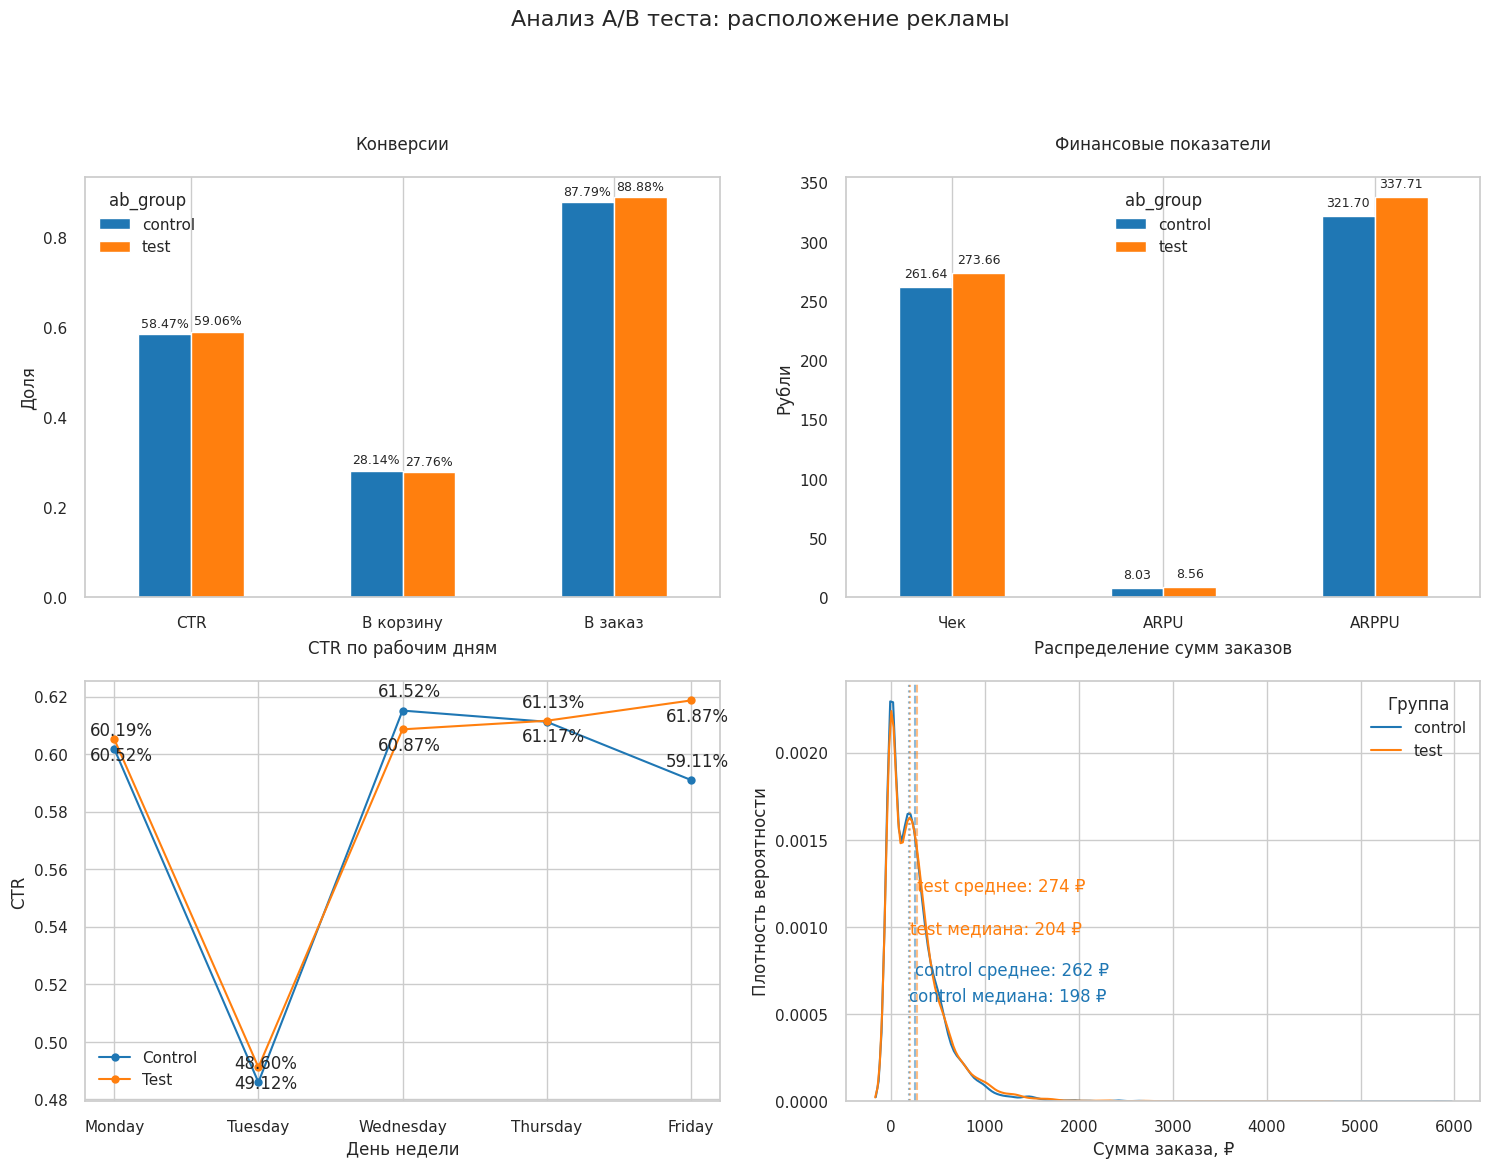


Статистически значимые улучшения найдены для следующих метрик:
- Метрика 'В заказ': изменение на 0.01 (1.2%), p-value = 0.0474

Рекомендация: Требуется дополнительное тестирование, так как ключевые метрики не показывают одновременно статистически значимых улучшений.


In [ ]:

warnings.filterwarnings('ignore')

# Настройки отображения
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
colors = ['#1f77b4', '#ff7f0e']

# Функция для расчета метрик
def calculate_metrics(df_group):
    # Уникальные клиенты
    unique_clients = df_group['client_id'].nunique()
    orders = df_group['is_orders_ads'].sum()

    # Для ARPPU: считаем уникальных клиентов, сделавших заказы
    paying_clients = df_group[df_group['is_orders_ads'] == 1]['client_id'].nunique()
    total_revenue = df_group['sum_orders_ads'].sum()

    return {
        'Клиенты': unique_clients,
        'Просмотры': df_group['cnt_view_ads'].sum(),
        'Клики': df_group['is_view_ads'].sum(),
        'Добавления': df_group['is_adds_ads'].sum(),
        'Заказы': orders,
        'Выручка': total_revenue,
        'CTR': df_group['is_view_ads'].sum() / df_group['cnt_view_ads'].sum() if df_group['cnt_view_ads'].sum() > 0 else 0,
        'В корзину': df_group['is_adds_ads'].sum() / df_group['is_view_ads'].sum() if df_group['is_view_ads'].sum() > 0 else 0,
        'В заказ': df_group['is_orders_ads'].sum() / df_group['is_adds_ads'].sum() if df_group['is_adds_ads'].sum() > 0 else 0,
        'Чек': total_revenue / orders if orders > 0 else 0,
        'ARPU': total_revenue / unique_clients if unique_clients > 0 else 0,
        'ARPPU': total_revenue / paying_clients if paying_clients > 0 else 0
    }

# Основные метрики по группам
results = df.groupby('ab_group').apply(lambda x: pd.Series(calculate_metrics(x))).T
print("Основные метрики по группам:")
display(results.style.format("{:.2f}"))

# Функция для проверки нормальности и выбора теста
def check_normality_and_test(control, test):
    # Проверка нормальности на подвыборке (не более 5000 наблюдений)
    if len(control) > 3:
        _, p_control = stats.shapiro(control.sample(min(5000, len(control))))
    else:
        p_control = 0

    if len(test) > 3:
        _, p_test = stats.shapiro(test.sample(min(5000, len(test))))
    else:
        p_test = 0

    if p_control < 0.05 or p_test < 0.05:
        # Непараметрический тест
        return stats.mannwhitneyu(control, test, alternative='two-sided').pvalue
    else:
        # Параметрический t-тест
        return stats.ttest_ind(control, test, equal_var=False).pvalue

# Функция для расчета p-value для всех метрик
def calculate_all_pvalues():
    pvalues = {}

    # 1. CTR (z-тест для пропорций)
    control_clicks = df[df['ab_group'] == 'control']['is_view_ads'].sum()
    control_views = df[df['ab_group'] == 'control']['cnt_view_ads'].sum()
    test_clicks = df[df['ab_group'] == 'test']['is_view_ads'].sum()
    test_views = df[df['ab_group'] == 'test']['cnt_view_ads'].sum()

    _, p_value_ctr = proportions_ztest([test_clicks, control_clicks], [test_views, control_views])
    pvalues['CTR'] = p_value_ctr

    # 2. Конверсия в корзину (z-тест для пропорций)
    control_adds = df[df['ab_group'] == 'control']['is_adds_ads'].sum()
    control_views = df[df['ab_group'] == 'control']['is_view_ads'].sum()
    test_adds = df[df['ab_group'] == 'test']['is_adds_ads'].sum()
    test_views = df[df['ab_group'] == 'test']['is_view_ads'].sum()

    _, p_value_add = proportions_ztest([test_adds, control_adds], [test_views, control_views])
    pvalues['В корзину'] = p_value_add

    # 3. Конверсия в заказ (z-тест для пропорций)
    control_orders = df[df['ab_group'] == 'control']['is_orders_ads'].sum()
    control_adds = df[df['ab_group'] == 'control']['is_adds_ads'].sum()
    test_orders = df[df['ab_group'] == 'test']['is_orders_ads'].sum()
    test_adds = df[df['ab_group'] == 'test']['is_adds_ads'].sum()

    _, p_value_order = proportions_ztest([test_orders, control_orders], [test_adds, control_adds])
    pvalues['В заказ'] = p_value_order

    # 4. ARPU (t-тест или U-тест)
    arpu_control = df[df['ab_group'] == 'control'].groupby('client_id')['sum_orders_ads'].sum()
    arpu_test = df[df['ab_group'] == 'test'].groupby('client_id')['sum_orders_ads'].sum()
    pvalues['ARPU'] = check_normality_and_test(arpu_control, arpu_test)

    # 5. ARPPU (t-тест или U-тест)
    arppu_control = df[(df['ab_group'] == 'control') & (df['is_orders_ads'] == 1)].groupby('client_id')['sum_orders_ads'].sum()
    arppu_test = df[(df['ab_group'] == 'test') & (df['is_orders_ads'] == 1)].groupby('client_id')['sum_orders_ads'].sum()
    pvalues['ARPPU'] = check_normality_and_test(arppu_control, arppu_test)

    # 6. Средний чек (t-тест или U-тест)
    check_control = df[df['ab_group'] == 'control'].groupby('client_id')['sum_orders_ads'].mean()
    check_test = df[df['ab_group'] == 'test'].groupby('client_id')['sum_orders_ads'].mean()
    pvalues['Чек'] = check_normality_and_test(check_control, check_test)

    return pvalues

# Вычисляем все p-values
all_pvalues = calculate_all_pvalues()

print("\nСтатистическая значимость (p-value) для всех метрик:")
display(pd.DataFrame(all_pvalues.items(), columns=['Метрика', 'p-value']).style.format({'p-value': "{:.4f}"}))

# Анализ по дням недели
df['day_of_week'] = df['date'].dt.day_name()
work_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_workdays = df[df['day_of_week'].isin(work_days)]

# Проверяем, что у нас есть данные для обеих групп
if 'control' in df_workdays['ab_group'].unique() and 'test' in df_workdays['ab_group'].unique():
    daily_metrics = df_workdays.groupby(['day_of_week', 'ab_group']).apply(
        lambda x: pd.Series(calculate_metrics(x))).unstack(level=1)

    # Упорядочиваем дни недели
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    daily_metrics = daily_metrics.reindex(day_order)

    print("\nМетрики по рабочим дням:")
    display(daily_metrics.style.format("{:.2f}"))

    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Анализ A/B теста: расположение рекламы', y=1.02, fontsize=16)

    # График 1: Конверсии
    results.loc[['CTR', 'В корзину', 'В заказ']].plot(kind='bar', ax=axes[0, 0], color=colors)
    axes[0, 0].set_title('Конверсии', pad=20)
    axes[0, 0].set_ylabel('Доля')
    axes[0, 0].grid(axis='y')
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

    for p in axes[0, 0].patches:
        height = p.get_height()
        axes[0, 0].annotate(f"{height:.2%}",
                           (p.get_x() + p.get_width()/2., height),
                           ha='center', va='bottom', xytext=(0, 3),
                           textcoords='offset points',
                            fontsize=9)

    # График 2: Финансовые показатели
    results.loc[['Чек', 'ARPU', 'ARPPU']].plot(kind='bar', ax=axes[0, 1], color=colors)
    axes[0, 1].set_title('Финансовые показатели', pad=20)
    axes[0, 1].set_ylabel('Рубли')
    axes[0, 1].grid(axis='y')
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

    for p in axes[0, 1].patches:
        height = p.get_height()
        axes[0, 1].annotate(f"{height:.2f}",
                          (p.get_x() + p.get_width()/2., height),
                          ha='center', va='bottom', xytext=(0, 5),
                          textcoords='offset points',
                          fontsize=9)

    # График 3: CTR по дням недели
    if ('CTR', 'control') in daily_metrics.columns:
        axes[1, 0].plot(daily_metrics[('CTR', 'control')], marker='o', color=colors[0], label='Control')
        axes[1, 0].plot(daily_metrics[('CTR', 'test')], marker='o', color=colors[1], label='Test')
        axes[1, 0].set_title('CTR по рабочим дням', pad=20)
        axes[1, 0].set_ylabel('CTR')
        axes[1, 0].set_xlabel('День недели')
        axes[1, 0].grid(True)
        axes[1, 0].legend()
        axes[1, 0].set_xticks(range(len(day_order)))
        axes[1, 0].set_xticklabels(day_order, rotation=0)

        for day_idx, day in enumerate(day_order):
            control_value = daily_metrics.loc[day, ('CTR', 'control')]
            test_value = daily_metrics.loc[day, ('CTR', 'test')]
            axes[1, 0].annotate(f"{control_value:.2%}", (day_idx, control_value),
                              textcoords="offset points", xytext=(5, 10), ha='center')
            axes[1, 0].annotate(f"{test_value:.2%}", (day_idx, test_value),
                              textcoords="offset points", xytext=(5, -15), ha='center')

    # График 4: Распределение сумм заказов
    # plt.figure(figsize=(12, 6))
    for color, group in zip(colors, ['control', 'test']):
        data = df[(df['ab_group'] == group) & (df['is_orders_ads'] == 1)]
        if not data.empty:
            sns.kdeplot(data['sum_orders_ads'], label=group, color=color)
            mean_val = data['sum_orders_ads'].mean()
            median_val = data['sum_orders_ads'].median()

            plt.axvline(mean_val, color=color, linestyle='--', alpha=0.5)
            plt.axvline(median_val, color=color, linestyle=':', alpha=0.5)

            y_max = plt.ylim()[1]
            offset = y_max * 0.30 if group == 'control' else y_max * 0.50

            plt.text(mean_val, offset,
                    f'{group} среднее: {mean_val:.0f} ₽',
                    color=color, ha='left')
            plt.text(median_val, offset * 0.8,
                    f'{group} медиана: {median_val:.0f} ₽',
                    color=color, ha='left')

    plt.title('Распределение сумм заказов', pad=20)
    plt.xlabel('Сумма заказа, ₽')
    plt.ylabel('Плотность вероятности')
    plt.legend(title='Группа')
    plt.grid(True)
    plt.show()

# Итоговые выводы
significant = [m for m, p in all_pvalues.items() if p < 0.05]
if significant:
    print("\nСтатистически значимые улучшения найдены для следующих метрик:")
    for metric in significant:
        if metric in results.index:
            diff = results.loc[metric, 'test'] - results.loc[metric, 'control']
            pct = diff / results.loc[metric, 'control'] * 100 if results.loc[metric, 'control'] != 0 else np.inf
            print(f"- Метрика '{metric}': изменение на {diff:.2f} ({pct:.1f}%), p-value = {all_pvalues[metric]:.4f}")
else:
    print("\nСтатистически значимые различия между тестовой и контрольной группами отсутствуют.")

# Рекомендация
if 'CTR' in significant and ('В заказ' in significant or 'ARPU' in significant or 'ARPPU' in significant):
    print("\nРекомендация: Принять предложенные изменения, так как ключевые метрики демонстрируют статистически значимые улучшения.")
else:
    print("\nРекомендация: Требуется дополнительное тестирование, так как ключевые метрики не показывают одновременно статистически значимых улучшений.")

# Анализ результатов A/B теста:

На основе предоставленных данных и результатов A/B теста можно сделать следующий вывод:

**Анализ p-value по ключевым метрикам:**

Метрика	p-value

CTR (кликабельность рекламы)	0.0823	Не достигает уровня значимости 0.05, тенденция к улучшению

В корзину	0.3481	Незначимый результат

В заказ	0.0474	Статистически значимое улучшение

ARPU	0.2442	Не значимо

ARPPU	0.1829	Не значимо

Чек	0.2467	Не значимо

**Общий анализ:**

Основные метрики, такие как CTR, конверсия в корзину не показывают статистически значимых отличий между контрольной и тестовой группами, за исключением метрики "В заказ", где p-value чуть ниже 0.05, что свидетельствует о возможном небольшом улучшении.

Метрики ARPU и ARPPU не демонстрируют значимых изменений.

В целом, разницы в выручке и среднем чеке также не достигли уровня статистической значимости.

**Дополнительный анализ по дням недели выявил:**

Значимое улучшение по метрике "В заказ" на уровне дня (p-value = 0.0474), что указывает на возможный эффект изменения в определенные дни.
Остальные метрики по дням недели не показывают статистически значимых различий.

**Общий вывод:**

Учитывая, что гипотеза о положительном влиянии изменения расположения рекламы на ключевые метрики не подтверждается статистически значимыми отличиями, можно заключить, что изменение расположения секции рекламы над основной секцией не привело к заметному улучшению взаимодействия пользователей с рекламой.

Основная гипотеза о положительном влиянии расположения рекламы на взаимодействие пользователей подтверждается частично:

Наблюдается улучшение конверсии в заказ

Нет значимого влияния на CTR

Финансовые показатели демонстрируют рост, но изменения не являются статистически значимыми

Стабильность эффекта варьируется по дням недели, что может указывать на внешние факторы влияния

**Рекомендации:**

Рекомендуется провести дополнительные тестирования с увеличением объема выборки или продолжительностью эксперимента для подтверждения выявленных тенденций и оценки их практической значимости.

Также стоит учитывать, что большинство метрик не демонстрируют существенных изменений, что говорит о необходимости пересмотра гипотезы или подхода к изменению интерфейса/функционала.